In [1]:
import pandas as pd
import mols2grid
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import PandasTools
import MDAnalysis as mda
import prolif as plf
import seaborn as sns

Generate analogs with REINVENT4

In [2]:
!reinvent sampling.toml

/home/pwalters/anaconda3/envs/reinvent4/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
18:28:17 <INFO> Started REINVENT 4.0.28 (C) AstraZeneca 2017, 2023 on 2024-06-02
18:28:17 <INFO> Command line: /home/pwalters/anaconda3/envs/reinvent4/bin/reinvent sampling.toml
18:28:17 <INFO> User pwalters on host PWALTERS-LNX
18:28:17 <INFO> Python version 3.10.13
18:28:17 <INFO> PyTorch version 2.2.0+cu121, git 8ac9b20d4b090c213799e81acf48a55ea8d437d6
18:28:17 <INFO> PyTorch compiled with CUDA version 12.1
18:28:17 <INFO> RDKit version 2022.09.5
18:28:17 <INFO> Platform Linux-5.4.0-150-generic-x86_64-with-glibc2.27
18:28:17 <INFO> CUDA driver version 465.19.01
18:28:17 <INFO> Number of PyTorch CUDA devices 1
18:28:17 <INFO> Using CPU x86_64
18:28:17 <INFO> Writing JSON config file to /home/pwalters/softwa

Read the REINVENT4 output

In [3]:
df = pd.read_csv("sampling.csv")

View the molecules

In [4]:
mols2grid.display(df)

MolGridWidget()

Remove odd ring systems

In [5]:
ring_system_lookup = uru.RingSystemLookup.default()

In [6]:
df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)

In [7]:
df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

In [8]:
df_ok = df.query('min_freq > 100').copy()

How many molecules were removed? 

In [9]:
len(df),len(df_ok)

(460, 234)

Prepare the protein for docking with Spruce 

In [10]:
!/usr/local/openeye/bin/spruce -in data/5s18.pdb -out data/5s18.oedu

          :jGf:               
        :jGDDDDf:             
      ,fDDDGjLDDDf,           Spruce
    ,fDDLt:   :iLDDL;         
  ;fDLt:         :tfDG;       
,jft:   ,ijfffji,   :iff      
     .jGDDDDDDDDDGt.          
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.        
   ;DDDj         tDDDi        
   ,DDDf         fDDD,         Copyright (c) 2019-2022
    LDDDt.     .fDDDj          OpenEye Scientific Software, Inc.
    .tDDDDfjtjfDDDGt          
      :ifGDDDDDGfi.            Version: 1.5.0.1
          .:::.                Built:   20220607
  ......................       OEChem version: 3.3.0.1 20220607
  DDDDDDDDDDDDDDDDDDDDDD       Platform: Ubuntu-18.04-g++7.5-x64
  DDDDDDDDDDDDDDDDDDDDDD  




  Licensed for the exclusive use of Relay Therapeutics, Inc..
  Licensed for use only in Camrbridge, MA.
  License expires on January 1, 2025.


Log written to : spruce_output.log
Run settings written to : spruce_settings.param


Write a SMILES file for conformer generation with Omega

In [11]:
df_ok['Name'] = [f"MOL{i:04d}" for i in range(0,len(df_ok))]

In [12]:
df_ok[["SMILES","Name"]].to_csv("data/analogs_rings_ok.smi",sep=" ",header=None, index=False)

Generate conformers with Omega

In [13]:
!/usr/local/openeye/bin/omega2 -in data/analogs_rings_ok.smi -out data/analogs_rings_ok.oeb -strictstereo false


          :jGf:             .d8888b. 88d8b.d8b. .d8888b. .d8888b. .d8888b.
        :jGDDDDf:           88'  `88 88'`88'`88 88ooood8 88'  `88 88'  `88
      ,fDDDGjLDDDf,         88.  .88 88  88  88 88.  ... 88.  .88 88.  .88
    ,fDDLt:   :iLDDL;       `88888P' dP  dP  dP `88888P' `8888P88 `88888P8
  ;fDLt:         :tfDG;                                       .88
,jft:   ,ijfffji,   :iff                                  d8888P
     .jGDDDDDDDDDGt.      
    ;GDDGt:''':tDDDG,          Copyright (c) 2004-2022
   .DDDG:       :GDDG.         OpenEye Scientific Software, Inc.
   ;DDDj         tDDDi    
   ,DDDf         fDDD,         Version: 4.2.0.1
    LDDDt.     .fDDDj          Built:   20220607
    .tDDDDfjtjfDDDGt           OEChem version: 3.3.0.1
      :ifGDDDDDGfi.            Platform: Ubuntu-18.04-g++7.5-x64
          .:::.                
  ......................       
  DDDDDDDDDDDDDDDDDDDDDD       
  DDDDDDDDDDDDDDDDDDDDDD       

Supported run modes:
  Single processor
  MPI Mu

Dock the conformers with OpenEye Hybrid

In [14]:
!/usr/local/openeye/bin/hybrid -receptor data/5s18.oedu -dbase data/analogs_rings_ok.oeb -out data/analogs_rings_ok_docked.sdf

          :jGf:               #     # #     # ######  ######  ### ###### 
        :jGDDDDf:             #     #  #   #  #     # #     #  #  #     #
      ,fDDDGjLDDDf,           #     #   # #   #     # #     #  #  #     #
    ,fDDLt:   :iLDDL;         #######    #    ######  ######   #  #     #
  ;fDLt:         :tfDG;       #     #    #    #     # #   #    #  #     #
,jft:   ,ijfffji,   :iff      #     #    #    #     # #    #   #  #     #
     .jGDDDDDDDDDGt.          #     #    #    ######  #     # ### ###### 
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.         Copyright (c) 2003-2022
   ;DDDj         tDDDi         OpenEye Scientific Software, Inc.
   ,DDDf         fDDD,         Version: 4.1.2.1
    LDDDt.     .fDDDj          Build date 20220607
    .tDDDDfjtjfDDDGt           
      :ifGDDDDDGfi.            Platform: Ubuntu-18.04-g++7.5-x64
          .:::.                Supported Run Modes:
  ......................         Single processor
  DDDDDDDDDDDDDDDDDDDDDD         

Read the docked molecules

,HYBRID receptor title,HYBRID receptor filename,HYBRID Chemgauss4 score,Dock Type,ID,ROMol
0,5S18(A) > WOY(A-201),data/5s18.oedu,-8.802896,Hybrid,MOL0143_3,
1,5S18(A) > WOY(A-201),data/5s18.oedu,-8.740950,Hybrid,MOL0061_3,
2,5S18(A) > WOY(A-201),data/5s18.oedu,-8.556643,Hybrid,MOL0145_35,
3,5S18(A) > WOY(A-201),data/5s18.oedu,-8.440889,Hybrid,MOL0223_1,
4,5S18(A) > WOY(A-201),data/5s18.oedu,-8.350897,Hybrid,MOL0076_13,
...,...,...,...,...,...,...
229,5S18(A) > WOY(A-201),data/5s18.oedu,-4.383670,Hybrid,MOL0091_2,
230,5S18(A) > WOY(A-201),data/5s18.oedu,-4.321407,Hybrid,MOL0120_2,
231,5S18(A) > WOY(A-201),data/5s18.oedu,-4.319513,Hybrid,MOL0212_3,
232,5S18(A) > WOY(A-201),data/5s18.oedu,-4.157134,Hybrid,MOL0218_1,

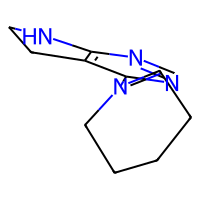
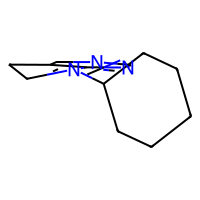
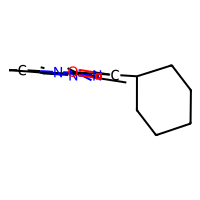
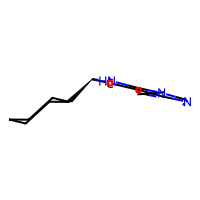
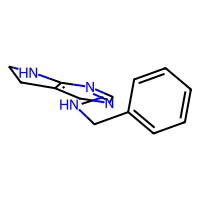
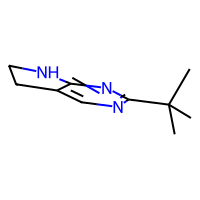
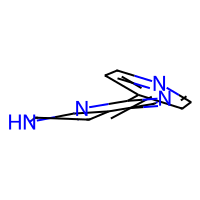
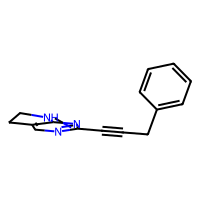
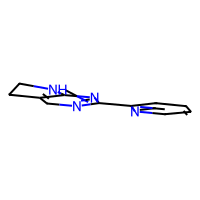
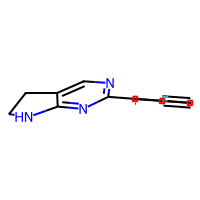

In [15]:
docked_df = PandasTools.LoadSDF("data/analogs_rings_ok_docked.sdf")
docked_df

In [16]:
PDB_FILEPATH = "data/5s18_protein.pdb"
SDF_FILEPATH = "data/analogs_rings_ok_docked.sdf"

In [17]:
fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(SDF_FILEPATH)
fp.run_from_iterable(suppl,prot,progress=True)
df = fp.to_dataframe()
df.columns = df.columns.droplevel(0)
df

  0%|          | 0/234 [00:00<?, ?it/s]

protein     ALA21.A                ASP22.A                        ILE23.A  \
interaction HBDonor VdWContact Hydrophobic HBDonor VdWContact Hydrophobic   
Frame                                                                       
0             False      False       False    True       True        True   
1             False      False       False   False       True        True   
2             False      False       False   False       True        True   
3             False      False       False    True       True        True   
4             False      False       False   False       True        True   
...             ...        ...         ...     ...        ...         ...   
229           False       True       False   False       True        True   
230           False      False       False   False       True        True   
231           False      False       False    True       True       False   
232           False      False       False   False       True       False   
233           False      False       False   False       True        True   

protein                               VAL24.A             ...   PHE156.A  \
interaction HBAcceptor VdWContact Hydrophobic VdWContact  ... HBAcceptor   
Frame                                                     ...              
0                 True       True       False      False  ...      False   
1                 True       True       False      False  ...      False   
2                 True       True       False      False  ...      False   
3                 True       True       False      False  ...       True   
4                 True       True       False      False  ...      False   
...                ...        ...         ...        ...  ...        ...   
229              False       True       False       True  ...      False   
230               True       True       False      False  ...      False   
231              False      False       False      False  ...      False   
232              False      False       False      False  ...      False   
233              False       True       False      False  ...       True   

protein                              ASP157.A                        \
interaction PiStacking VdWContact Hydrophobic HBAcceptor VdWContact   
Frame                                                                 
0                False       True        True      False      False   
1                False       True       False      False      False   
2                False       True       False      False      False   
3                False       True       False      False      False   
4                False       True       False      False      False   
...                ...        ...         ...        ...        ...   
229              False       True       False      False      False   
230              False       True       False      False      False   
231              False       True       False      False      False   
232              False       True       False      False      False   
233              False       True       False      False      False   

protein        LEU160.A               DMS202.A             
interaction Hydrophobic VdWContact Hydrophobic VdWContact  
Frame                                                      
0                 False      False       False      False  
1                  True      False       False      False  
2                  True       True       False      False  
3                 False      False       False      False  
4                  True      False       False      False  
...                 ...        ...         ...        ...  
229               False      False       False      False  
230               False      False       False      False  
231               False      False       False      False  
232               False      False       False      False  
233               False      False       False      False  

[234 rows x 45 colum

Text(0.5, 54.249999999999986, 'Protein Interaction')

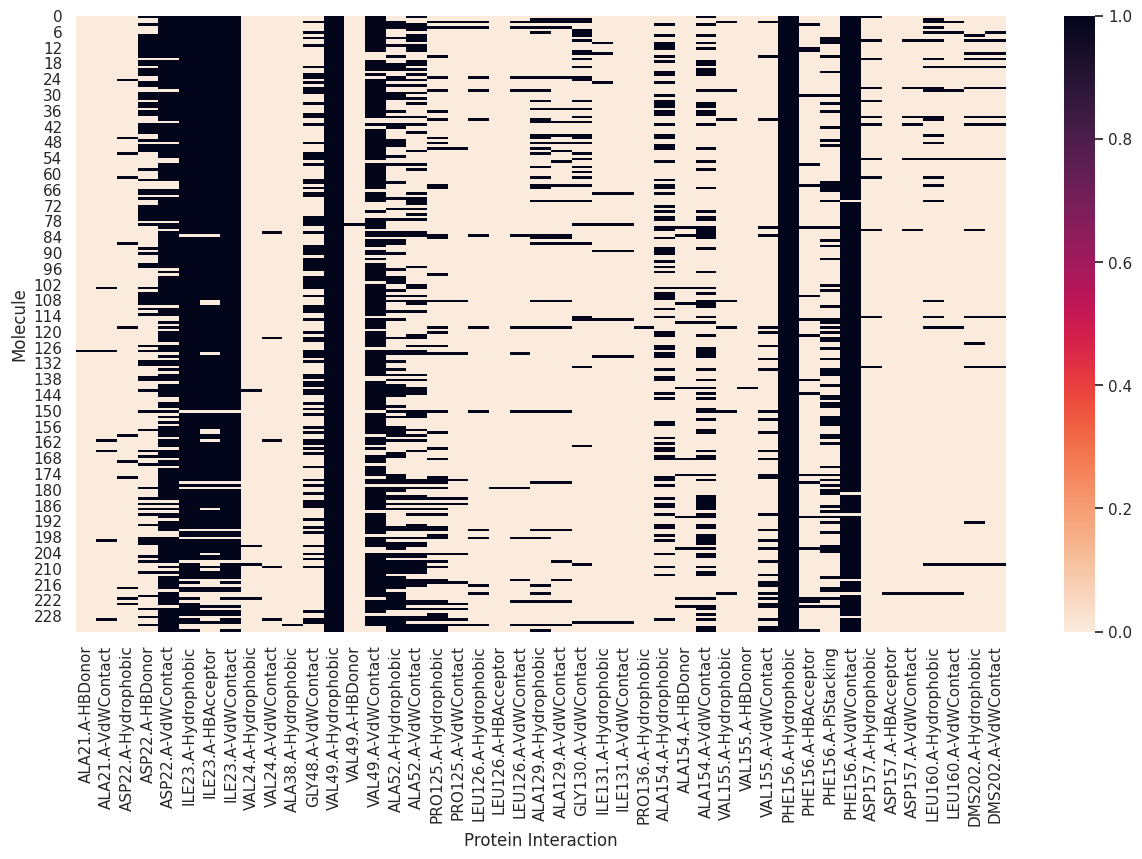

In [18]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(df,cmap=sns.cm.rocket_r)
ax.set_ylabel("Molecule")
ax.set_xlabel("Protein Interaction")